Random Forest - RMSE: 11913544713.860762, R²: -0.0012213439296164808
Training Time: 0.60 seconds
Predicted price for the property: ₦132,570,813.40


/Users/ademola/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


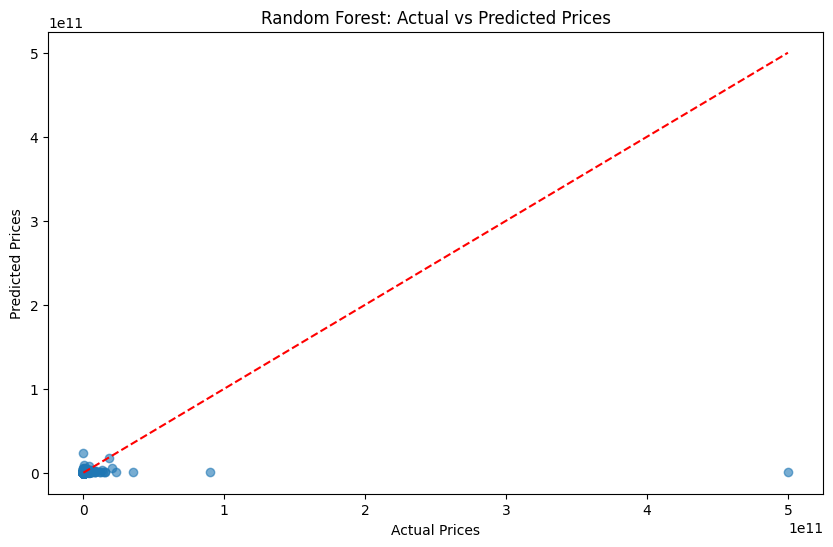

In [9]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from fuzzywuzzy import process  # For fuzzy matching
import time

# Load data from JSON file or your data source
property_data = pd.read_json('properties.json')

# Adjusted function to clean the 'rooms' field
def clean_rooms_info(rooms):
    if pd.isna(rooms) or not isinstance(rooms, str):
        return [np.nan, np.nan, np.nan, np.nan]
    
    # Remove ' Save' and any irrelevant trailing text
    rooms = rooms.replace(' Save', '').strip()
    
    # Extract numbers associated with room types using regex
    bedrooms = bathrooms = toilets = parking_spaces = np.nan

    if 'Bedrooms' in rooms:
        bedrooms_match = re.search(r'(\d+)\s*Bedrooms?', rooms)
        if bedrooms_match:
            bedrooms = int(bedrooms_match.group(1))
    
    if 'Bathrooms' in rooms:
        bathrooms_match = re.search(r'(\d+)\s*Bathrooms?', rooms)
        if bathrooms_match:
            bathrooms = int(bathrooms_match.group(1))

    if 'Toilets' in rooms:
        toilets_match = re.search(r'(\d+)\s*Toilets?', rooms)
        if toilets_match:
            toilets = int(toilets_match.group(1))

    if 'Parking Spaces' in rooms:
        parking_spaces_match = re.search(r'(\d+)\s*Parking Spaces?', rooms)
        if parking_spaces_match:
            parking_spaces = int(parking_spaces_match.group(1))
    
    return [bedrooms, bathrooms, toilets, parking_spaces]

# Apply the cleaning function to the 'rooms' field
property_data[['Bedrooms', 'Bathrooms', 'Toilets', 'Parking Spaces']] = property_data['rooms'].apply(
    lambda x: pd.Series(clean_rooms_info(x))
)

# Convert numerical columns to proper types
property_data['Bedrooms'] = pd.to_numeric(property_data['Bedrooms'], errors='coerce')
property_data['Bathrooms'] = pd.to_numeric(property_data['Bathrooms'], errors='coerce')
property_data['Toilets'] = pd.to_numeric(property_data['Toilets'], errors='coerce')
property_data['Parking Spaces'] = pd.to_numeric(property_data['Parking Spaces'], errors='coerce')

# Clean the 'price' column (remove non-numeric characters and convert to numeric)
property_data['price'] = property_data['price'].replace('[\₦\$,]', '', regex=True).astype(float)

# Fill missing values in numerical columns
property_data['Bedrooms'] = property_data['Bedrooms'].fillna(property_data['Bedrooms'].median())
property_data['Bathrooms'] = property_data['Bathrooms'].fillna(property_data['Bathrooms'].median())
property_data['Toilets'] = property_data['Toilets'].fillna(property_data['Toilets'].median())
property_data['Parking Spaces'] = property_data['Parking Spaces'].fillna(property_data['Parking Spaces'].median())

# One-Hot Encoding for 'location' to emphasize its importance
property_data = pd.get_dummies(property_data, columns=['location'])

# Interaction Term: Multiply Bedrooms and Bathrooms
property_data['Bedrooms_Bathrooms'] = property_data['Bedrooms'] * property_data['Bathrooms']

# Remove rows with missing price
property_data.dropna(subset=['price'], inplace=True)

# Prepare features (X) and target (y)
X = property_data.drop(columns=['price', 'rooms'])
y = property_data['price']

# Ensure all columns are numeric
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_columns) > 0:
    X[non_numeric_columns] = X[non_numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill any remaining NaN values with 0 to avoid errors in scaling
X = X.fillna(0)

# Normalize numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Dimensionality Reduction using PCA
pca = PCA(n_components=20)  # Keep the top 20 principal components to speed up training
X_reduced = pca.fit_transform(X_scaled)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train a regression model (Optimized Random Forest)
start_time = time.time()  # Start time for training
price_model_rf = RandomForestRegressor(
    n_estimators=50,  # Reduced number of trees
    max_depth=10,  # Limit the depth of each tree
    random_state=42,
    n_jobs=-1  # Use multiple cores for parallel processing
)
price_model_rf.fit(X_train, y_train)
training_time = time.time() - start_time  # Calculate training time

# Predict on the test set
y_pred_rf = price_model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf}, R²: {r2_rf}")
print(f"Training Time: {training_time:.2f} seconds")

# Function to predict the price based on features and location with one-hot encoding
def predict_price(bedrooms, bathrooms, toilets, parking_spaces, location):
    # Create a DataFrame for the input features
    input_data = pd.DataFrame([{
        'Bedrooms': bedrooms,
        'Bathrooms': bathrooms,
        'Toilets': toilets,
        'Parking Spaces': parking_spaces,
        'Bedrooms_Bathrooms': bedrooms * bathrooms  # Interaction term
    }])
    
    # One-hot encode location; if not found, create dummy columns efficiently
    location_columns = {f'location_{location}': 1} if f'location_{location}' in X.columns else {}
    
    # Add missing columns with 0 values
    all_location_columns = {col: 0 for col in X.columns if col.startswith('location_')}
    all_location_columns.update(location_columns)
    
    # Create a DataFrame for the location encoding
    location_data = pd.DataFrame([all_location_columns])
    
    # Concatenate the input data with the location data
    input_data = pd.concat([input_data, location_data], axis=1)

    # Ensure columns are consistent with training data
    input_data = input_data.reindex(columns=X.columns, fill_value=0)
    
    # Normalize the input features
    input_data_scaled = scaler.transform(input_data)
    
    # Apply PCA transformation
    input_data_reduced = pca.transform(input_data_scaled)

    # Predict the price using the trained model
    predicted_price = price_model_rf.predict(input_data_reduced)[0]
    
    return predicted_price

# Example input features for a new property
bedrooms = 3
bathrooms = 2
toilets = 2
parking_spaces = 1
location = "Wuse, Abuja"  # Example location

# Predict the price
predicted_price = predict_price(bedrooms, bathrooms, toilets, parking_spaces, location)
print(f"Predicted price for the property: ₦{predicted_price:,.2f}")

# Plot Actual vs Predicted Prices for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()
